# Ethereum Price Prediciton 

## Modeling and Preprocessing

## 1. Preprocessing

Since our objective is time-series analysis, our primary focus here will be how to best split our test and train data sets. Some considerations here are that we will likely want our test data split to be analogous with the time nearest where we are forecasting from, either by seasonality or simply the most recent time nearest where we are forecasting from.

In [636]:
#import relevant modules
import sys
import os
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
%matplotlib inline

In [637]:
#establish a base figure size and style for our plots
plt.rcParams["figure.figsize"] = (18,10)
plt.style.use('ggplot')

In [638]:
#!pip install libpython

In [639]:
#!pip install pystan==2.17.1.0

#!pip install fbprophet==0.6

#!pip install --upgrade fbprophet

In [640]:
pd.set_option('display.max_rows', 500)

In [641]:
ETH = pd.read_csv('Data\data_enhanced.csv',index_col='Date', parse_dates=True)
features = pd.read_csv('Data\engineered_features.csv',index_col='Date', parse_dates=True)

In [642]:
ETH.head(10)

Open      High       Low     Close     Volume  Year  Month  \
Date                                                                         
2015-08-07  2.831620  3.536610  2.521120  2.772120   164329.0  2015      8   
2015-08-08  2.793760  2.798810  0.714725  0.753325   674188.0  2015      8   
2015-08-09  0.706136  0.879810  0.629191  0.701897   532170.0  2015      8   
2015-08-10  0.713989  0.729854  0.636546  0.708448   405283.0  2015      8   
2015-08-11  0.708087  1.131410  0.663235  1.067860  1463100.0  2015      8   
2015-08-12  1.058750  1.289940  0.883608  1.217440  2150620.0  2015      8   
2015-08-13  1.222240  1.965070  1.171990  1.827670  4068680.0  2015      8   
2015-08-14  1.810920  2.261880  1.754750  1.827870  4637030.0  2015      8   
2015-08-15  1.802890  1.877240  1.570980  1.688900  2554360.0  2015      8   
2015-08-16  1.684350  1.695240  1.089810  1.566030  3550790.0  2015      8   

            Week  Weekday     Price  LogPrice     LogVol  
Date                                                      
2015-08-07    32        4  2.801870  1.030287  12.009626  
2015-08-08    32        5  1.773543  0.572979  13.421264  
2015-08-09    32        6  0.704017 -0.350953  13.184718  
2015-08-10    33        0  0.711218 -0.340776  12.912341  
2015-08-11    33        1  0.887973 -0.118813  14.196068  
2015-08-12    33        2  1.138095  0.129356  14.581267  
2015-08-13    33        3  1.524955  0.421965  15.218829  
2015-08-14    33        4  1.819395  0.598504  15.349585  
2015-08-15    33        5  1.745895  0.557267  14.753312  
2015-08-16    33        6  1.625190  0.485625  15.082681

In [643]:
ETH[['LogPrice']].tail(10)

LogPrice
Date                
2021-09-18  8.135851
2021-09-19  8.126036
2021-09-20  8.053357
2021-09-21  7.962371
2021-09-22  7.979523
2021-09-23  8.044546
2021-09-24  8.020637
2021-09-25  7.982152
2021-09-26  8.004467
2021-09-27  8.030832

In [644]:
ETH.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2244 entries, 2015-08-07 to 2021-09-27
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      2244 non-null   float64
 1   High      2244 non-null   float64
 2   Low       2244 non-null   float64
 3   Close     2244 non-null   float64
 4   Volume    2244 non-null   float64
 5   Year      2244 non-null   int64  
 6   Month     2244 non-null   int64  
 7   Week      2244 non-null   int64  
 8   Weekday   2244 non-null   int64  
 9   Price     2244 non-null   float64
 10  LogPrice  2244 non-null   float64
 11  LogVol    2244 non-null   float64
dtypes: float64(8), int64(4)
memory usage: 227.9 KB


In [645]:
missing = pd.concat([ETH.isnull().sum(), 100*ETH.isnull().mean()],axis=1)
missing.columns=['count','%']
missing.sort_values(by=['count','%'])

count    %
Open          0  0.0
High          0  0.0
Low           0  0.0
Close         0  0.0
Volume        0  0.0
Year          0  0.0
Month         0  0.0
Week          0  0.0
Weekday       0  0.0
Price         0  0.0
LogPrice      0  0.0
LogVol        0  0.0

In [646]:
#resampling for weekly timeseries
y=ETH[['Price']].resample('W').mean()
#y = ETH[['Price']]
y.head()

Price
Date                
2015-08-09  1.759810
2015-08-16  1.350389
2015-08-23  1.328926
2015-08-30  1.198094
2015-09-06  1.313124

In [647]:
split=int(len(ETH['Price']) * 0.8) 
y_train, y_test = ETH['Price'][0:split], ETH['Price'][split:len(ETH['Price'])]

In [648]:
y_train.shape, y_test.shape

((1795,), (449,))

## 2.0 Modeling

We will be testing and considering several time-series models, including: ARIMA, exponential smoothing, tbats and Facebook Prophet models. For exponential smoothing, we will likely look to use either the double or triple (also known as Holt_winters Exponential Smoothing) variants since we know our time-series has trend and we will decide between these two based on whether we determine if seasonality is present as well.

In [649]:
rolmean=y.rolling(window=12).mean()

rolstd = y.rolling(window=12).std()

print(rolmean,rolstd)

                  Price
Date                   
2015-08-09          NaN
2015-08-16          NaN
2015-08-23          NaN
2015-08-30          NaN
2015-09-06          NaN
2015-09-13          NaN
2015-09-20          NaN
2015-09-27          NaN
2015-10-04          NaN
2015-10-11          NaN
2015-10-18          NaN
2015-10-25     1.018805
2015-11-01     0.950755
2015-11-08     0.917910
2015-11-15     0.883335
2015-11-22     0.863447
2015-11-29     0.828976
2015-12-06     0.804490
2015-12-13     0.802018
2015-12-20     0.811634
2015-12-27     0.827833
2016-01-03     0.850631
2016-01-10     0.883683
2016-01-17     0.937321
2016-01-24     0.990271
2016-01-31     1.111566
2016-02-07     1.243327
2016-02-14     1.553413
2016-02-21     1.857286
2016-02-28     2.280012
2016-03-06     2.947139
2016-03-13     3.821214
2016-03-20     4.741816
2016-03-27     5.605909
2016-04-03     6.489318
2016-04-10     7.244255
2016-04-17     7.809269
2016-04-24     8.311984
2016-05-01     8.753465
2016-05-08     9

<AxesSubplot:xlabel='Date'>

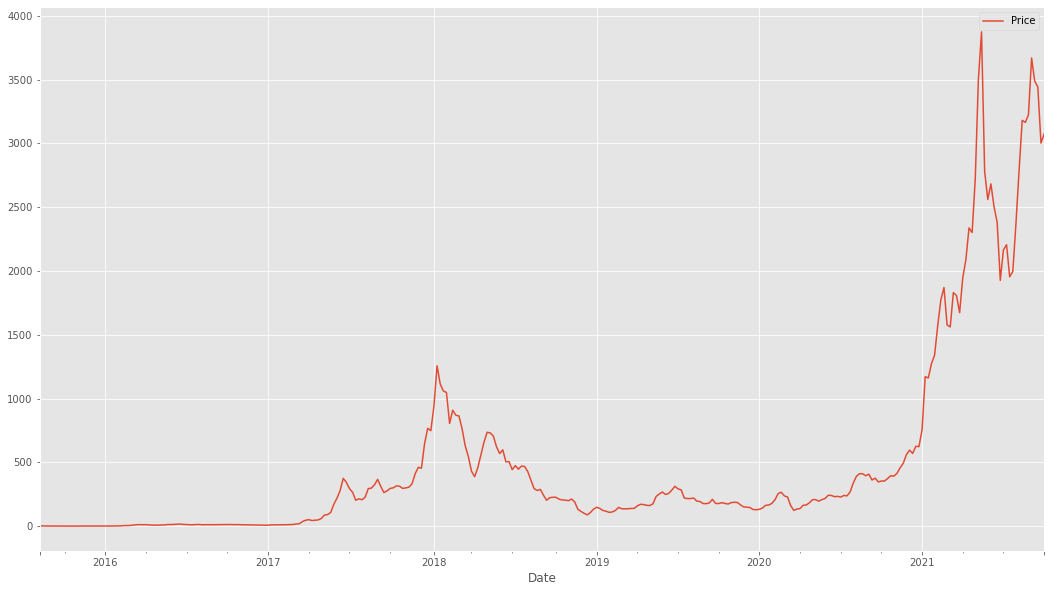

In [650]:
y.plot()

In [651]:
#Aggregating our times
#df_agg=ETH.groupby('Date')[['Price']].sum()

In [652]:
#checking that our index is still datetime
#type(df_agg.index)

Text(0, 0.5, 'Seasonality')

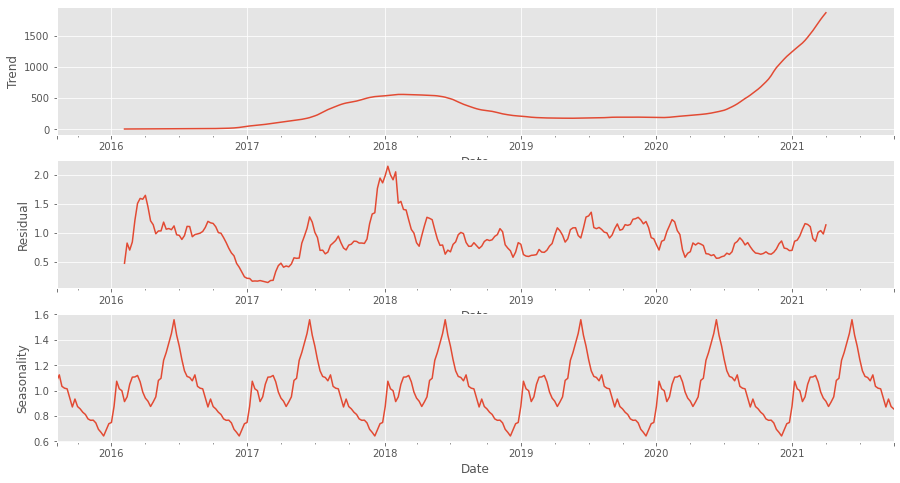

In [653]:
decomposition = sm.tsa.seasonal_decompose(y,model = 'multiplicative')

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
decomposition.trend.plot(ax=ax1)
decomposition.resid.plot(ax=ax2)
decomposition.seasonal.plot(ax=ax3)

ax1.set_ylabel("Trend")
ax2.set_ylabel("Residual")
ax3.set_ylabel("Seasonality")

In [654]:
#performing kpss test for stationarity as prelimiary test
from statsmodels.tsa.stattools import kpss

kpss(y)

(0.8392481556733852,
 0.01,
 17,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [655]:
from statsmodels.tsa.stattools import adfuller

print('Results of Dicky-Fuller Test:')
dftest = adfuller(y,autolag='AIC')

dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dicky-Fuller Test:
Test Statistic                   1.439468
p-value                          0.997286
#lags used                      13.000000
Number of Observations Used    308.000000
Critical Value (1%)             -3.451761
Critical Value (5%)             -2.870970
Critical Value (10%)            -2.571794
dtype: float64


In [656]:
def test_stationarity(timeseries):
    
    #Determining rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries,color='blue',label='Original')
    mean = plt.plot(movingAverage,color='red',label='Rolling Mean')
    std = plt.plot(movingSTD,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

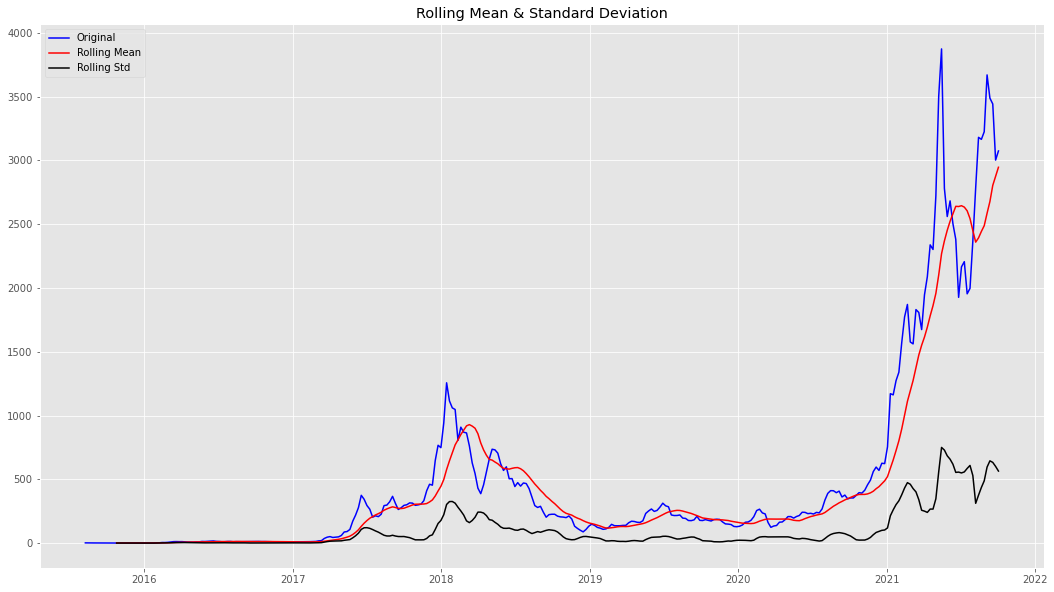

Results of Dickey-Fuller Test:
Test Statistic                   1.439468
p-value                          0.997286
#lags used                      13.000000
Number of Observations Used    308.000000
Critical Value (1%)             -3.451761
Critical Value (5%)             -2.870970
Critical Value (10%)            -2.571794
dtype: float64


In [657]:
test_stationarity(y)

In [658]:
y_diff =y.diff().dropna()

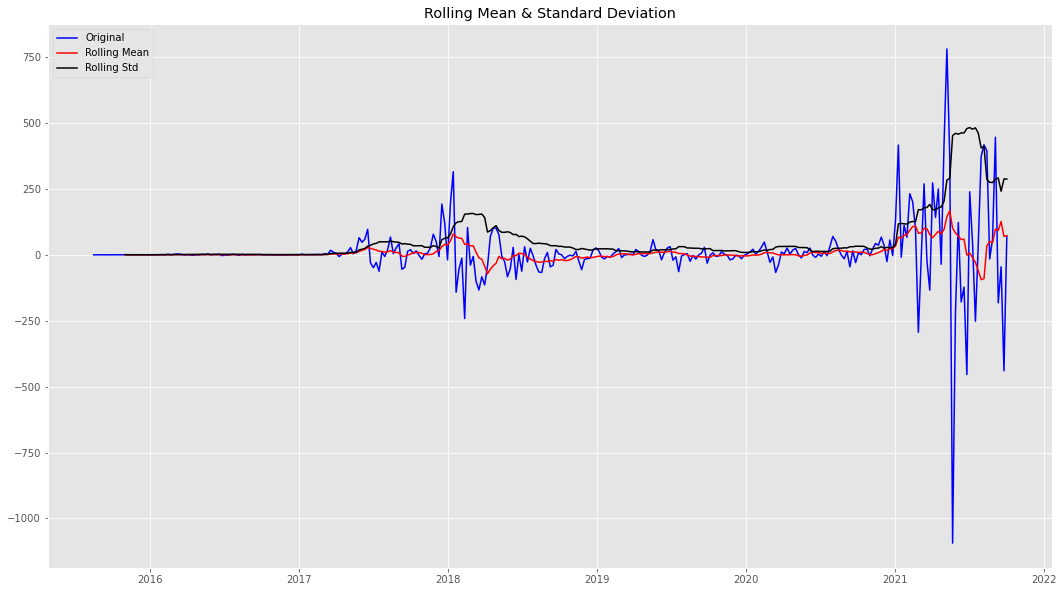

Results of Dickey-Fuller Test:
Test Statistic                  -2.246887
p-value                          0.189670
#lags used                      17.000000
Number of Observations Used    303.000000
Critical Value (1%)             -3.452118
Critical Value (5%)             -2.871127
Critical Value (10%)            -2.571878
dtype: float64


In [659]:
test_stationarity(y_diff)

In [660]:
y_log=np.log(y)

In [661]:
kpss(y_diff.dropna())

(0.42735991633478887,
 0.06536210502810824,
 17,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

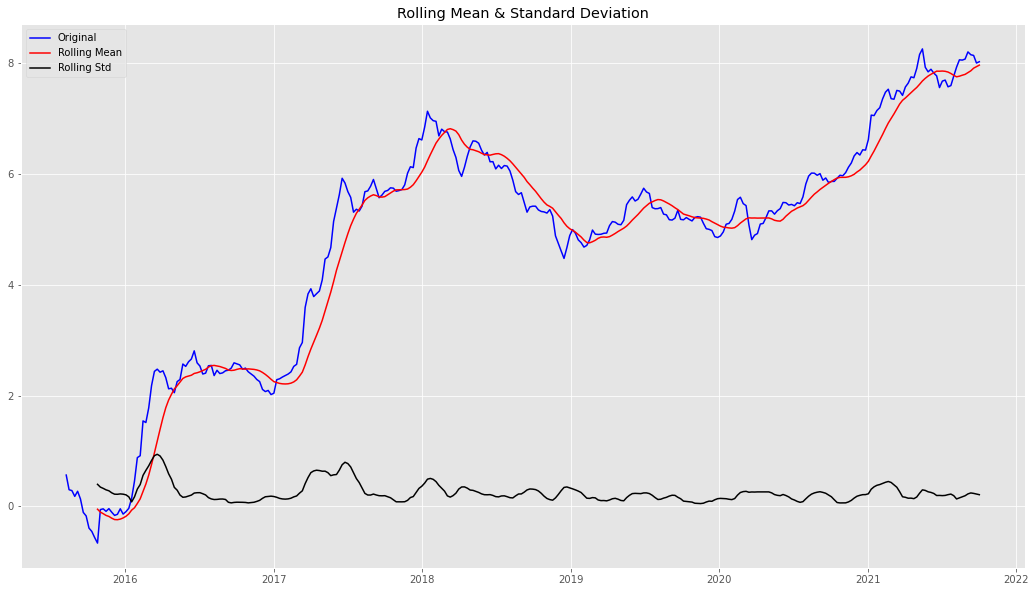

Results of Dickey-Fuller Test:
Test Statistic                  -1.590277
p-value                          0.488476
#lags used                       2.000000
Number of Observations Used    319.000000
Critical Value (1%)             -3.451017
Critical Value (5%)             -2.870643
Critical Value (10%)            -2.571620
dtype: float64


In [662]:
test_stationarity(y_log)

<AxesSubplot:xlabel='Date'>

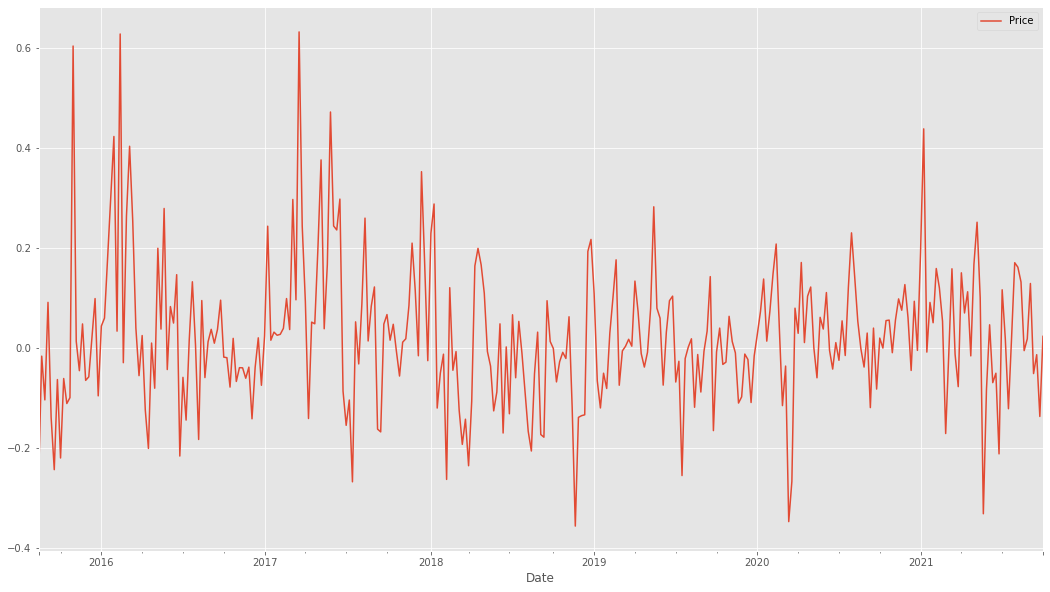

In [663]:
y_log_diff = y_log.diff().dropna()
y_log_diff.plot()

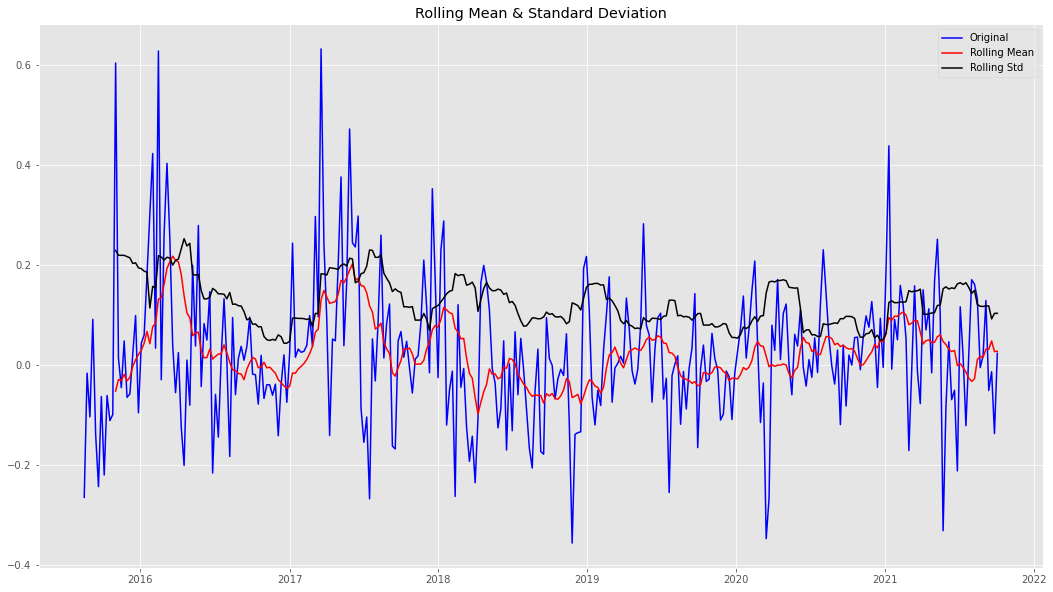

Results of Dickey-Fuller Test:
Test Statistic                -9.207717e+00
p-value                        1.924696e-15
#lags used                     1.000000e+00
Number of Observations Used    3.190000e+02
Critical Value (1%)           -3.451017e+00
Critical Value (5%)           -2.870643e+00
Critical Value (10%)          -2.571620e+00
dtype: float64


In [664]:
test_stationarity(y_log_diff)

y_log_diff rejects the null hypothesis via the ad fuller test.

In [665]:
#creating moving average and std for y_log
movingAverage = y_log.rolling(window=4).mean()
movingSTD = y_log.rolling(window=4).std()

In [666]:
y_log_minusmovingAverage = y_log - movingAverage
y_log_minusmovingAverage.head(10)

y_log_minusmovingAverage.dropna(inplace=True)
y_log_minusmovingAverage.head()

Price
Date                
2015-08-30 -0.151943
2015-09-06  0.012933
2015-09-13 -0.084109
2015-09-20 -0.228954
2015-09-27 -0.203536

In [667]:
y_log_minusmovingAverage.tail()

Price
Date                
2021-09-05  0.105156
2021-09-12  0.031187
2021-09-19 -0.002924
2021-09-26 -0.121897
2021-10-03 -0.053983

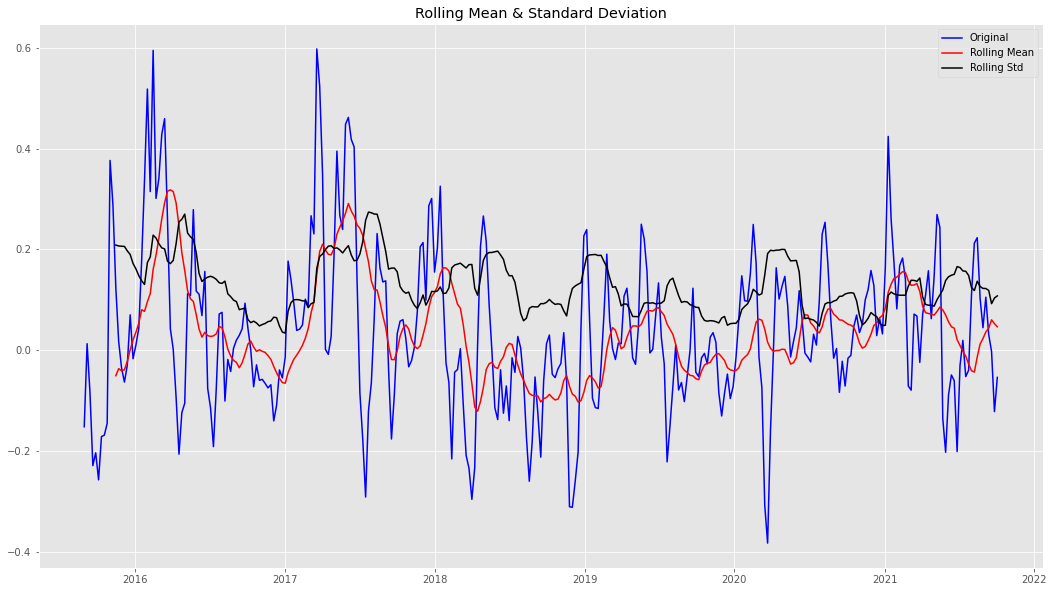

Results of Dickey-Fuller Test:
Test Statistic                -6.810738e+00
p-value                        2.119530e-09
#lags used                     3.000000e+00
Number of Observations Used    3.150000e+02
Critical Value (1%)           -3.451281e+00
Critical Value (5%)           -2.870760e+00
Critical Value (10%)          -2.571682e+00
dtype: float64


In [668]:
test_stationarity(y_log_minusmovingAverage)

<AxesSubplot:xlabel='Date'>

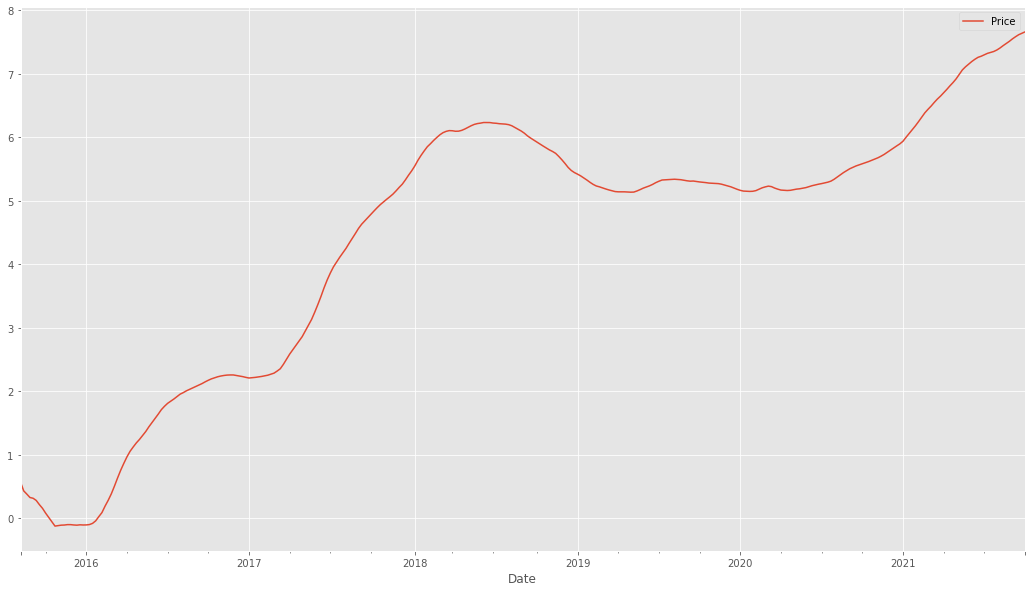

In [669]:
expentialDecayWeightedAverage = y_log.ewm(halflife=12,min_periods=0,adjust=True).mean()
expentialDecayWeightedAverage.plot()

Text(0, 0.5, 'Seasonality')

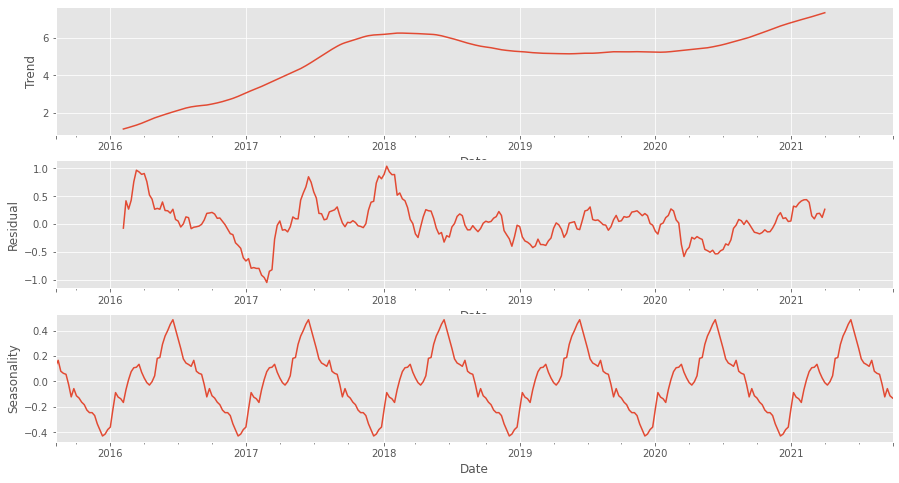

In [670]:
#plotting decomposition of our log scale timeseries
decomposition = sm.tsa.seasonal_decompose(y_log)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
decomposition.trend.plot(ax=ax1)
decomposition.resid.plot(ax=ax2)
decomposition.seasonal.plot(ax=ax3)

ax1.set_ylabel("Trend")
ax2.set_ylabel("Residual")
ax3.set_ylabel("Seasonality")

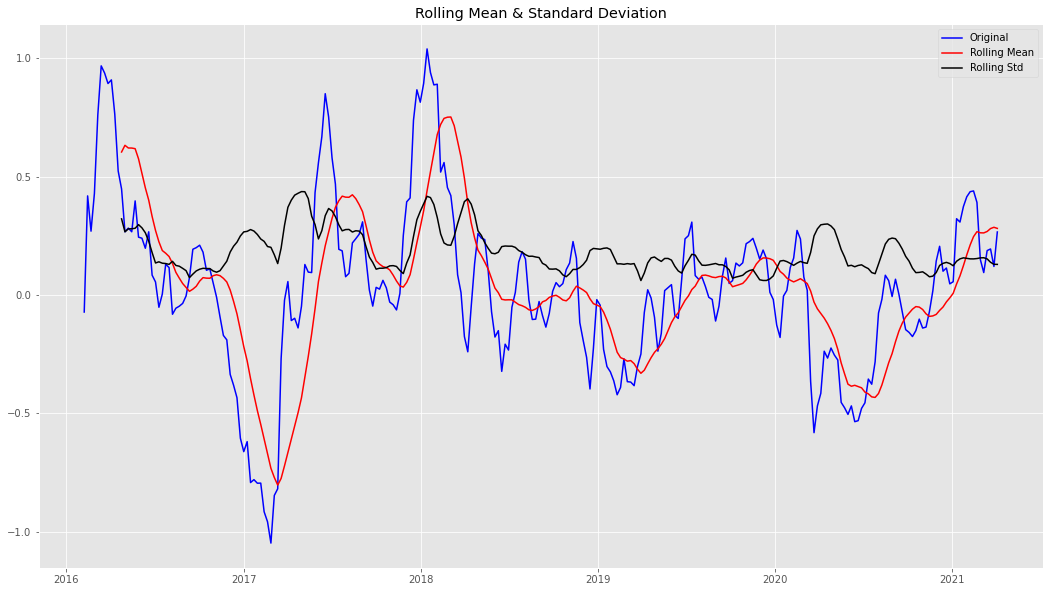

Results of Dickey-Fuller Test:
Test Statistic                  -4.017634
p-value                          0.001321
#lags used                       2.000000
Number of Observations Used    267.000000
Critical Value (1%)             -3.455081
Critical Value (5%)             -2.872427
Critical Value (10%)            -2.572571
dtype: float64


In [671]:
#testing stationarity of our noise (residuals)
decomposedLogData = decomposition.resid
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

<AxesSubplot:xlabel='Date'>

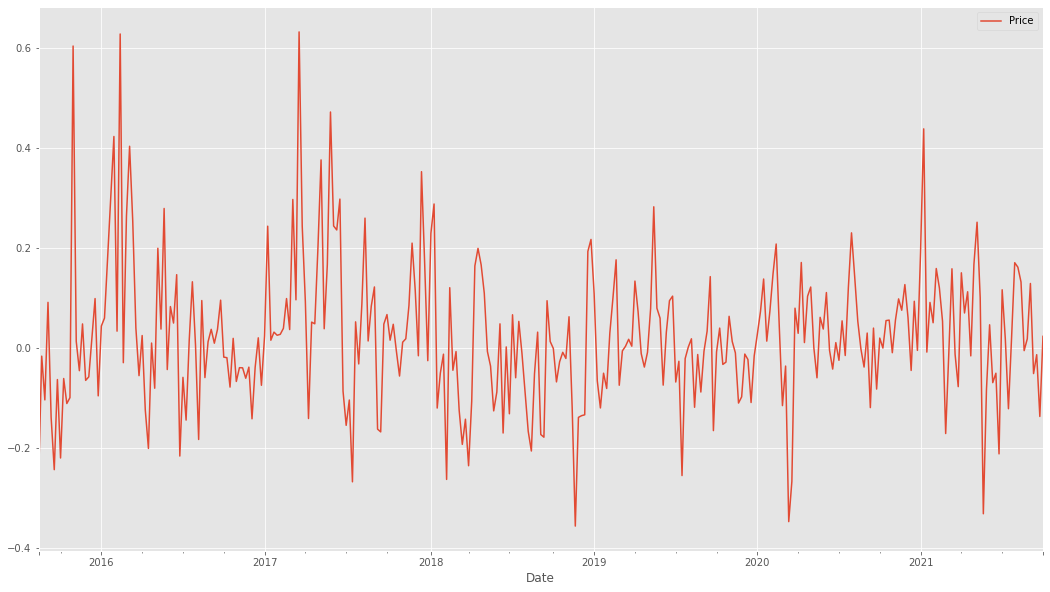

In [672]:
y_log_diff.plot()

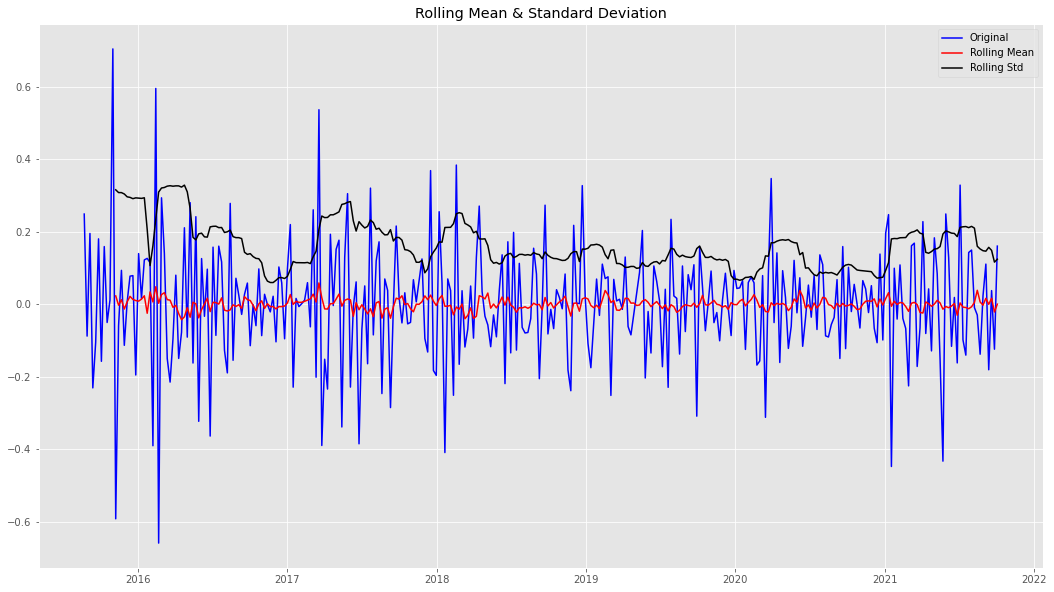

Results of Dickey-Fuller Test:
Test Statistic                -1.001192e+01
p-value                        1.769377e-17
#lags used                     1.000000e+01
Number of Observations Used    3.090000e+02
Critical Value (1%)           -3.451691e+00
Critical Value (5%)           -2.870939e+00
Critical Value (10%)          -2.571778e+00
dtype: float64


In [673]:
y_log_diff_shifted = y_log_diff - y_log_diff.shift()
y_log_diff_shifted.dropna(inplace=True)
test_stationarity(y_log_diff_shifted)

## 2.1 ARIMA Model

In [674]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

C:\Users\nicho\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.



Text(0.5, 1.0, 'Partial Autocorrelation Function')

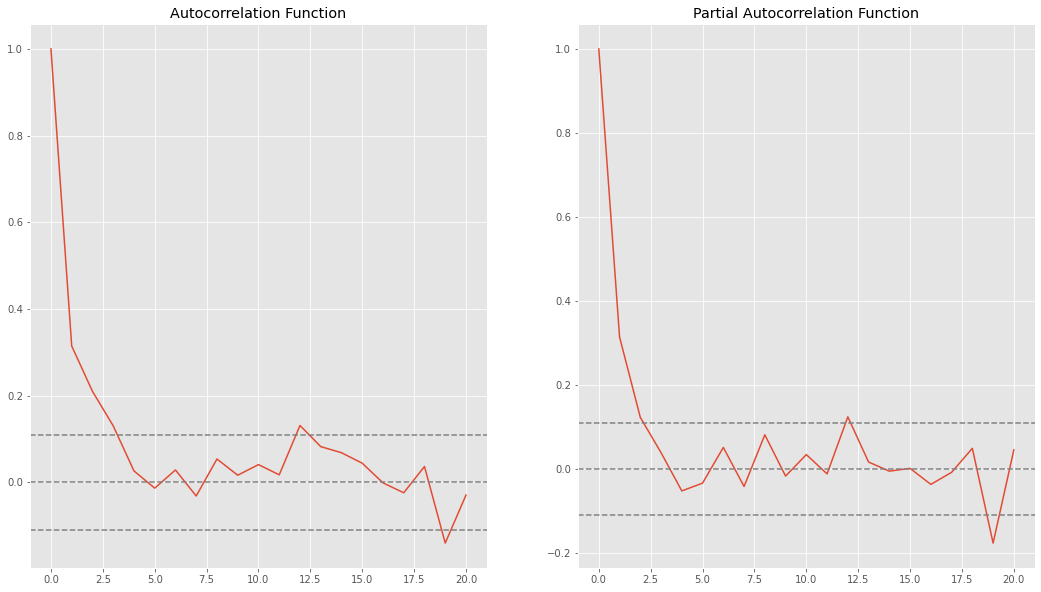

In [196]:
#ACF and PCF Plots:
from statsmodels.tsa.stattools import acf,pacf

lag_acf = acf(y_log_diff, nlags=20)
lag_pacf = pacf(y_log_diff, nlags=20, method='ols')

#Plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PCF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

We will be using the ACF plot to find our P value and PACF for find our Q value. Looking at where the ACF and PACF functions touch zero for the first times we can see the P value is roughly equal to 3.75 or 4, and the Q value is around 3.

In [675]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    split=int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

In [676]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [702]:
# Choose range of values to evaluate for our ARIMA model order
p_values = [x for x in range(0, 6)]
d_values = [x for x in range(1, 2)]
q_values = [x for x in range(0, 5)]

In [705]:
import warnings
warnings.filterwarnings("ignore")
evaluate_models(y_log_diff['Price'],p_values,d_values,q_values)

ARIMA(0, 1, 0) MSE=0.022
ARIMA(0, 1, 1) MSE=0.015
ARIMA(0, 1, 2) MSE=0.014
ARIMA(0, 1, 3) MSE=0.015
ARIMA(0, 1, 4) MSE=0.016
ARIMA(1, 1, 0) MSE=0.020
ARIMA(1, 1, 1) MSE=0.014
ARIMA(1, 1, 2) MSE=0.014
ARIMA(1, 1, 3) MSE=0.015
ARIMA(2, 1, 0) MSE=0.018
ARIMA(2, 1, 1) MSE=0.014
ARIMA(2, 1, 2) MSE=0.014
ARIMA(3, 1, 0) MSE=0.017
ARIMA(3, 1, 1) MSE=0.014
ARIMA(4, 1, 0) MSE=0.016
ARIMA(4, 1, 1) MSE=0.015
ARIMA(5, 1, 0) MSE=0.019
ARIMA(5, 1, 1) MSE=0.015
ARIMA(5, 1, 3) MSE=0.015
Best ARIMA(0, 1, 2) MSE=0.014


Plotting ARIMA model


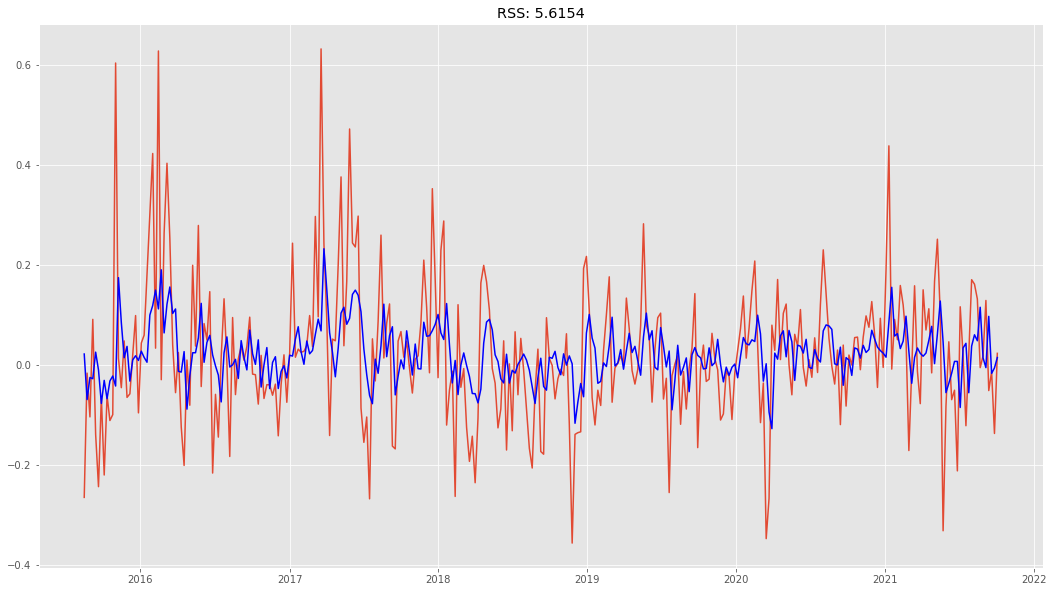

In [714]:
from statsmodels.tsa.arima_model import ARIMA

#ARIMA Model
model = ARIMA(y_log, order=(4,1,3))
model_fit = model.fit(disp=-1)
plt.plot(y_log_diff)
plt.plot(model_fit.fittedvalues,color='blue')
plt.title('RSS: %.4f'% sum((model_fit.fittedvalues-y_log_diff['Price'])**2))
print('Plotting ARIMA model')

In [715]:
#forecasting
ARIMA_forecast = model_fit.forecast(52)

In [716]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                  321
Model:                 ARIMA(4, 1, 3)   Log Likelihood                 194.671
Method:                       css-mle   S.D. of innovations              0.131
Date:                Sun, 14 Nov 2021   AIC                           -371.342
Time:                        23:07:22   BIC                           -337.399
Sample:                    08-16-2015   HQIC                          -357.789
                         - 10-03-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0223      0.013      1.736      0.083      -0.003       0.047
ar.L1.D.Price    -0.8817      0.275     -3.211      0.001      -1.420      -0.343
ar.L2.D.Price    -0.5269      0.235     -2.239      0.025      -0.988      -0.066
ar.L3.D.Price     0.4365      0.182      2.394      0.017       0.079       0.794
ar.L4.D.Price     0.1614      0.100      1.621      0.105      -0.034       0.357
ma.L1.D.Price     1.1801      0.276      4.271      0.000       0.639       1.722
ma.L2.D.Price     1.0021      0.327      3.065      0.002       0.361       1.643
ma.L3.D.Price     0.0018      0.277      0.006      0.995      -0.541       0.545
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5793           -0.8272j            1.0099           -0.3472
AR.2           -0.5793           +0.8272j            1.0099            0.3472
AR.3            1.8102           -0.0000j            1.8102           -0.0000
AR.4           -3.3555           -0.0000j            3.3555           -0.5000
MA.1           -0.5891           -0.8080j            1.0000           -0.3503
MA.2           -0.5891           +0.8080j            1.0000            0.3503
MA.3         -567.7500           -0.0000j          567.7500           -0.5000
-----------------------------------------------------------------------------
"""

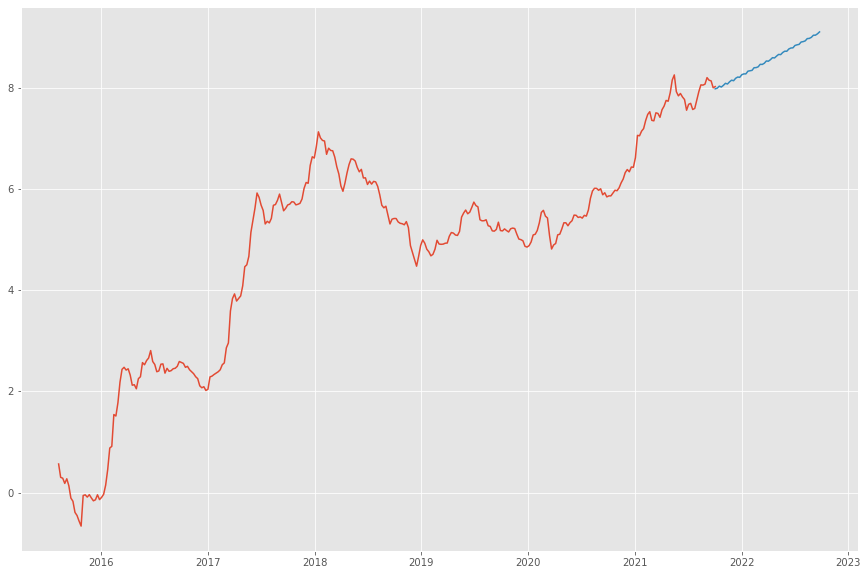

In [717]:
# Declare a variable called forecast_period with the amount of weeks to forecast, and
# create a range of future dates that is 52 periods, or 1 year forecast
forecast_period = 52
date_range = pd.date_range(y_log_diff.index[-1], periods = forecast_period, 
              freq='W-SUN').strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions
future_weeks = pd.DataFrame(date_range, columns = ['Week'])
# Let's now convert the 'Week' column to a datetime object with to_datetime 
future_weeks['W'] = pd.to_datetime(future_weeks['Week'])
future_weeks.set_index('Week', inplace = True)
future_weeks.index = pd.to_datetime(future_weeks.index)
future_weeks=future_weeks.drop('W',axis=1)
future_weeks['Prediction'] = ARIMA_forecast[0]
future_weeks = future_weeks.asfreq('W-SUN')


# Plot future predictions
plt.figure(figsize=(15,10))
plt.plot(y_log)
plt.plot(future_weeks['Prediction'])
plt.show()

In [718]:
predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Date
2015-08-16    0.022263
2015-08-23   -0.068958
2015-08-30   -0.024655
2015-09-06   -0.027207
2015-09-13    0.026005
2015-09-20   -0.009726
2015-09-27   -0.076702
2015-10-04   -0.030547
2015-10-11   -0.067349
2015-10-18   -0.031680
2015-10-25   -0.021820
2015-11-01   -0.041820
2015-11-08    0.175189
2015-11-15    0.085237
2015-11-22    0.014882
2015-11-29    0.037568
2015-12-06   -0.031990
2015-12-13    0.010518
2015-12-20    0.018776
2015-12-27    0.009367
2016-01-03    0.027944
2016-01-10    0.015482
2016-01-17    0.005803
2016-01-24    0.100368
2016-01-31    0.119458
2016-02-07    0.150231
2016-02-14    0.112605
2016-02-21    0.190869
2016-02-28    0.064543
2016-03-06    0.121774
2016-03-13    0.156478
2016-03-20    0.103455
2016-03-27    0.112476
2016-04-03   -0.012450
2016-04-10   -0.013894
2016-04-17    0.027094
2016-04-24   -0.088111
2016-05-01   -0.021102
2016-05-08    0.024761
2016-05-15    0.024863
2016-05-22    0.054548
2016-05-29    0.123698
2016-06-05    0.005726
2016-0

In [719]:
predictions_ARIMA_diff_cumsum=predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

Date
2015-08-16    0.022263
2015-08-23   -0.046694
2015-08-30   -0.071349
2015-09-06   -0.098556
2015-09-13   -0.072552
2015-09-20   -0.082277
2015-09-27   -0.158979
2015-10-04   -0.189526
2015-10-11   -0.256875
2015-10-18   -0.288555
2015-10-25   -0.310375
2015-11-01   -0.352195
2015-11-08   -0.177006
2015-11-15   -0.091769
2015-11-22   -0.076888
2015-11-29   -0.039320
2015-12-06   -0.071310
2015-12-13   -0.060792
2015-12-20   -0.042016
2015-12-27   -0.032649
2016-01-03   -0.004705
2016-01-10    0.010777
2016-01-17    0.016580
2016-01-24    0.116949
2016-01-31    0.236406
2016-02-07    0.386637
2016-02-14    0.499243
2016-02-21    0.690112
2016-02-28    0.754655
2016-03-06    0.876428
2016-03-13    1.032907
2016-03-20    1.136361
2016-03-27    1.248838
2016-04-03    1.236387
2016-04-10    1.222493
2016-04-17    1.249587
2016-04-24    1.161476
2016-05-01    1.140374
2016-05-08    1.165135
2016-05-15    1.189998
2016-05-22    1.244546
2016-05-29    1.368244
2016-06-05    1.373970
2016-0

In [720]:
predictions_ARIMA_log = pd.Series(y_log['Price'].iloc[0], index=y_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Date
2015-08-09    0.565206
2015-08-16    0.587469
2015-08-23    0.518511
2015-08-30    0.493856
2015-09-06    0.466649
Freq: W-SUN, dtype: float64

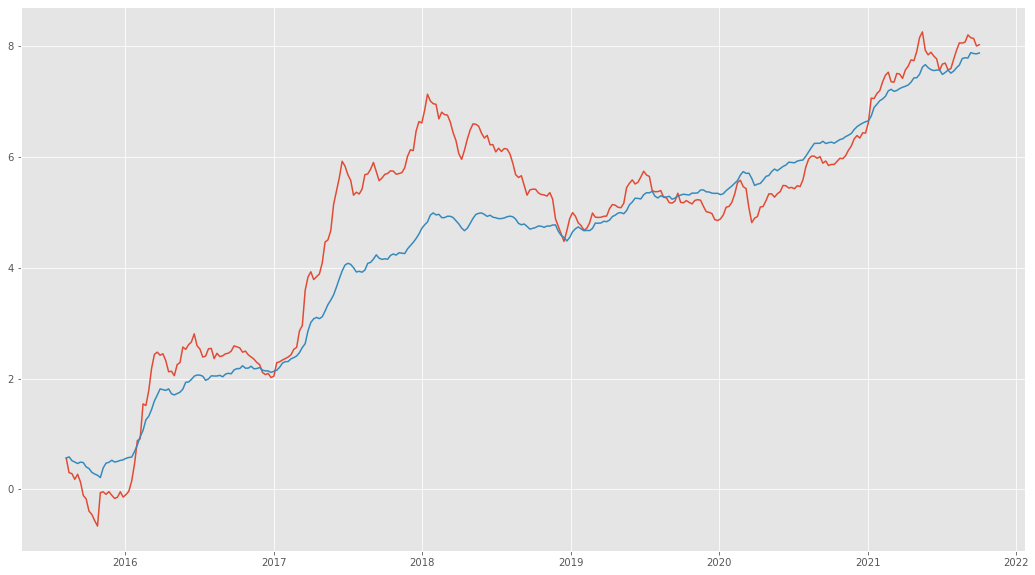

In [721]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(y_log['Price'])
plt.plot(predictions_ARIMA_log)

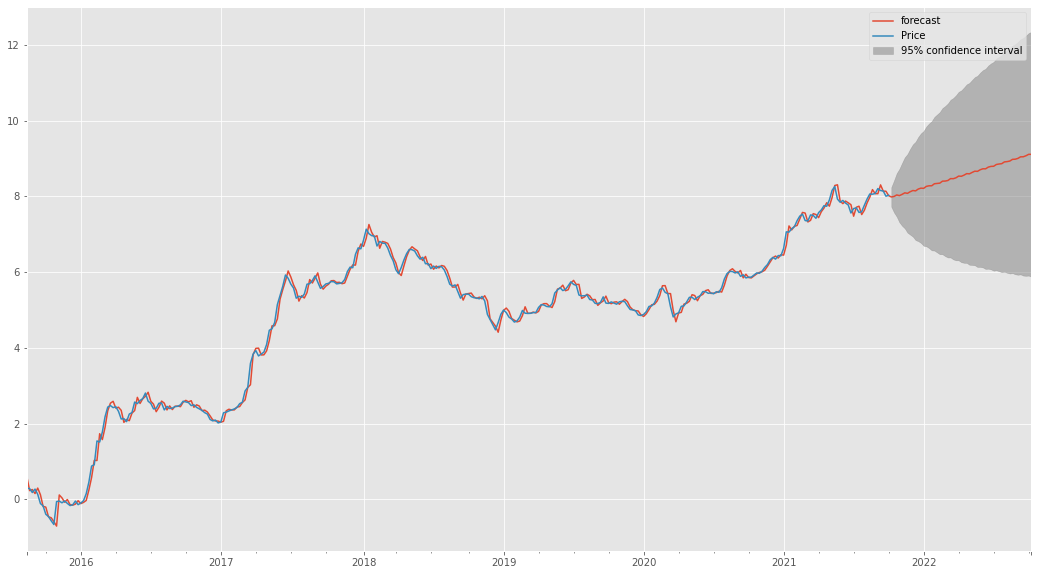

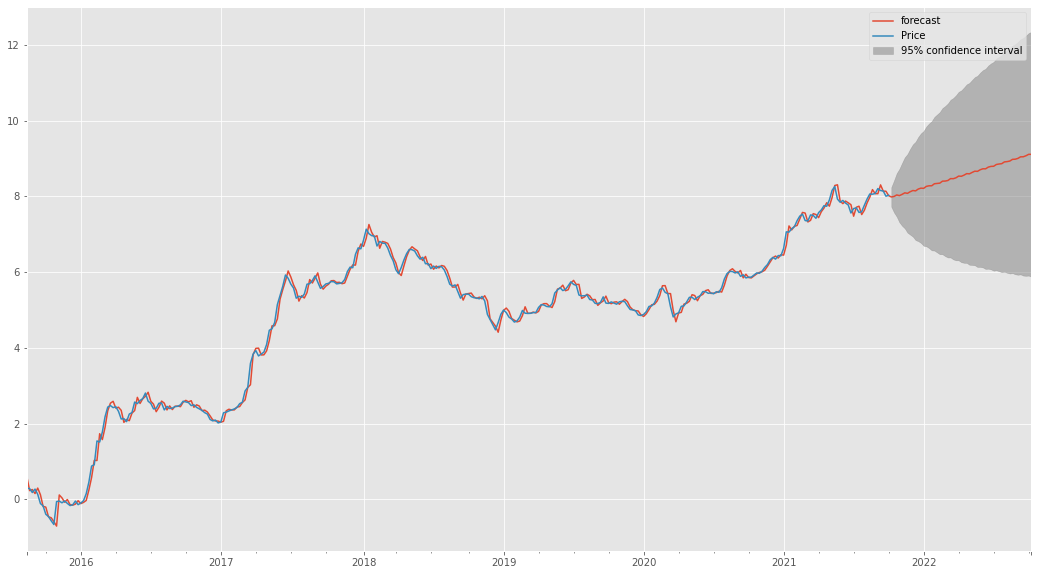

In [722]:
model_fit.plot_predict(1,374)

In [723]:
ARIMA_MSE = mean_squared_error(y_log['Price'],predictions_ARIMA_log)
ARIMA_MAE = mean_absolute_error(y_log['Price'],predictions_ARIMA_log)
ARIMA_MSE, ARIMA_MAE

(0.6627372765182725, 0.6007977660404914)

In [724]:
mean_squared_error(y['Price'],predictions_ARIMA), mean_absolute_error(y['Price'],predictions_ARIMA)

(104364.45966928024, 180.90194109813515)

## 2.2 FB Prophet Model

In [608]:
from prophet import Prophet

In [609]:
ETH = pd.read_csv('Data\data_enhanced.csv',parse_dates=True)

In [610]:
ETH.head()

Open      High       Low     Close     Volume  Year  Month  Week  \
0  2.831620  3.536610  2.521120  2.772120   164329.0  2015      8    32   
1  2.793760  2.798810  0.714725  0.753325   674188.0  2015      8    32   
2  0.706136  0.879810  0.629191  0.701897   532170.0  2015      8    32   
3  0.713989  0.729854  0.636546  0.708448   405283.0  2015      8    33   
4  0.708087  1.131410  0.663235  1.067860  1463100.0  2015      8    33   

   Weekday     Price  LogPrice     LogVol        Date  
0        4  2.801870  1.030287  12.009626  2015-08-07  
1        5  1.773543  0.572979  13.421264  2015-08-08  
2        6  0.704017 -0.350953  13.184718  2015-08-09  
3        0  0.711218 -0.340776  12.912341  2015-08-10  
4        1  0.887973 -0.118813  14.196068  2015-08-11

In [611]:
df = pd.DataFrame(ETH[['Price','Date']])

In [612]:
df['Date']=pd.to_datetime(df['Date'])

In [613]:
df=df.set_index('Date')

In [614]:
df['Price']=df[['Price']].resample('W').mean()

In [615]:
df['ds']=df.index

In [616]:
df=df.dropna()

In [617]:
df.head()

Price         ds
Date                           
2015-08-09  1.759810 2015-08-09
2015-08-16  1.350389 2015-08-16
2015-08-23  1.328926 2015-08-23
2015-08-30  1.198094 2015-08-30
2015-09-06  1.313124 2015-09-06

In [618]:
df.shape

(321, 2)

In [619]:
df['y']=np.log(df['Price'])

In [620]:
df=df.drop(['Price'], axis=1)

In [621]:
df.head()

ds         y
Date                           
2015-08-09 2015-08-09  0.565206
2015-08-16 2015-08-16  0.300393
2015-08-23 2015-08-23  0.284371
2015-08-30 2015-08-30  0.180732
2015-09-06 2015-09-06  0.272409

In [622]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 321 entries, 2015-08-09 to 2021-09-26
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      321 non-null    datetime64[ns]
 1   y       321 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.5 KB


### 2.2.1 Simple FB Prophet Model

In [623]:
model = Prophet()
fitted_model = model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [542]:
future=model.make_future_dataframe(periods=52,freq='W')
future.tail()

ds
368 2022-08-28
369 2022-09-04
370 2022-09-11
371 2022-09-18
372 2022-09-25

In [543]:
future.shape

(373, 1)

In [544]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
368 2022-08-28  10.316960    9.543340   11.048919
369 2022-09-04  10.293147    9.501934   11.053747
370 2022-09-11  10.270964    9.476274   11.048836
371 2022-09-18  10.253099    9.463796   11.045040
372 2022-09-25  10.234800    9.477365   11.078896

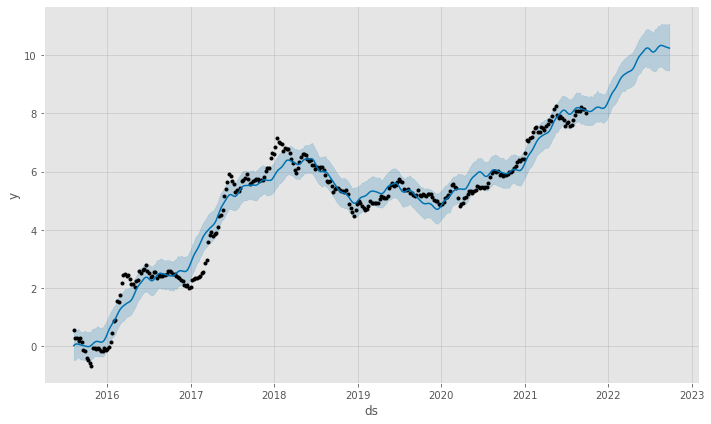

In [545]:
fig1=model.plot(forecast)

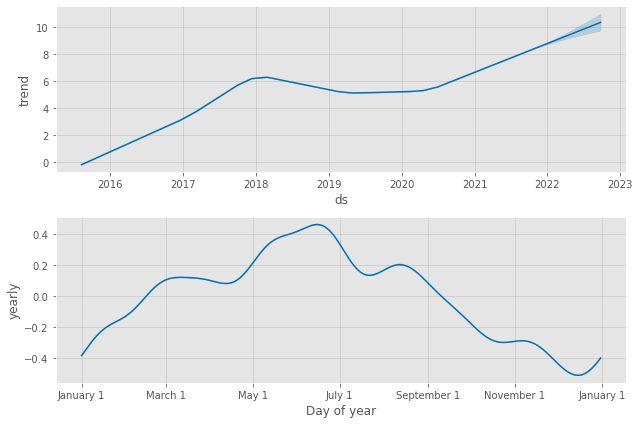

In [546]:
fig2=model.plot_components(forecast)

In [547]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

In [548]:
forecast.tail()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
368 2022-08-28  10.192783    9.543340   11.048919     9.654593    10.748192   
369 2022-09-04  10.233702    9.501934   11.053747     9.683762    10.807828   
370 2022-09-11  10.274622    9.476274   11.048836     9.709204    10.864356   
371 2022-09-18  10.315542    9.463796   11.045040     9.727952    10.925849   
372 2022-09-25  10.356461    9.477365   11.078896     9.755724    10.984493   

     additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
368        0.124178              0.124178              0.124178  0.124178   
369        0.059445              0.059445              0.059445  0.059445   
370       -0.003658             -0.003658             -0.003658 -0.003658   
371       -0.062442             -0.062442             -0.062442 -0.062442   
372       -0.121661             -0.121661             -0.121661 -0.121661   

     yearly_lower  yearly_upper  multiplicative_terms  \
368      0.124178      0.124178                   0.0   
369      0.059445      0.059445                   0.0   
370     -0.003658     -0.003658                   0.0   
371     -0.062442     -0.062442                   0.0   
372     -0.121661     -0.121661                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper       yhat  
368                         0.0                         0.0  10.316960  
369                         0.0                         0.0  10.293147  
370                         0.0                         0.0  10.270964  
371                         0.0                         0.0  10.253099  
372                         0.0                         0.0  10.234800

In [549]:
forecast.shape

(373, 16)

### 2.2.2 FB Prophet Model with Cross Validation

In [746]:
from prophet.diagnostics import cross_validation
df_cv1 = cross_validation(model, initial='550 days', period='135 days', horizon = '275 days')


INFO:prophet:Making 11 forecasts with cutoffs between 2017-04-15 00:00:00 and 2020-12-25 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

In [747]:
df_cv1.head()

ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2017-04-16  3.729804    3.623144    3.835703  3.840924 2017-04-15
1 2017-04-23  3.761873    3.643526    3.869975  3.889652 2017-04-15
2 2017-04-30  3.940814    3.807789    4.074013  4.089788 2017-04-15
3 2017-05-07  4.203644    4.052137    4.371205  4.466684 2017-04-15
4 2017-05-14  4.460587    4.269301    4.669131  4.505473 2017-04-15

In [748]:
df_cv1['cutoff'].unique()

array(['2017-04-15T00:00:00.000000000', '2017-08-28T00:00:00.000000000',
       '2018-01-10T00:00:00.000000000', '2018-05-25T00:00:00.000000000',
       '2018-10-07T00:00:00.000000000', '2019-02-19T00:00:00.000000000',
       '2019-07-04T00:00:00.000000000', '2019-11-16T00:00:00.000000000',
       '2020-03-30T00:00:00.000000000', '2020-08-12T00:00:00.000000000',
       '2020-12-25T00:00:00.000000000'], dtype='datetime64[ns]')

In [749]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv1)
df_p.head()

horizon       mse      rmse       mae      mape     mdape     smape  \
0 27 days  0.182460  0.427153  0.344422  0.058084  0.045337  0.058251   
1 28 days  0.183964  0.428910  0.348350  0.058729  0.049619  0.058922   
2 29 days  0.181947  0.426553  0.343019  0.057946  0.049619  0.058138   
3 30 days  0.215500  0.464220  0.371027  0.061961  0.050848  0.062061   
4 31 days  0.212423  0.460894  0.367725  0.061539  0.050848  0.061598   

   coverage  
0  0.302326  
1  0.290698  
2  0.325581  
3  0.325581  
4  0.337209

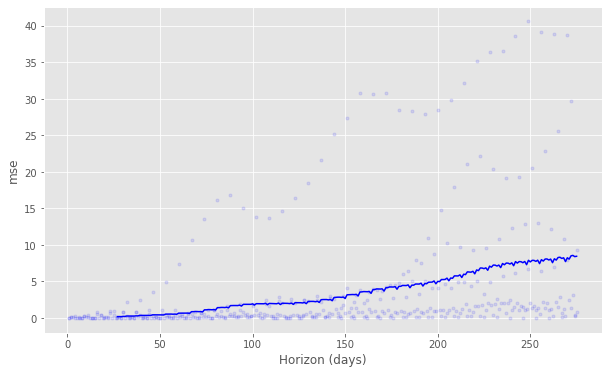

In [751]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mse')

### 2.2.3 Hyperparameter Tuning

In [603]:
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in tqdm(all_params):
    model = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(model, cutoffs=df_cv1['cutoff'].unique(), horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000232E8BED490>
  6%|█████▏                                                                             | 1/16 [00:13<03:29, 13.94s/it]INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000232E8C00130>
 12%|██████████▍                                                                        | 2/16 [00:28<03:21, 14.41s/it]INFO:

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  1.487358
1                     0.001                     0.10  1.620615
2                     0.001                     1.00  1.621759
3                     0.001                    10.00  1.616161
4                     0.010                     0.01  1.401321
5                     0.010                     0.10  1.532399
6                     0.010                     1.00  1.537673
7                     0.010                    10.00  1.526411
8                     0.100                     0.01  0.734281
9                     0.100                     0.10  0.774533
10                    0.100                     1.00  0.793919
11                    0.100                    10.00  0.804443
12                    0.500                     0.01  0.472883
13                    0.500                     0.10  0.453315
14                    0.500                     1.00  0

In [606]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0}


### 2.2.4 Run CV Model Again with New Parameters

In [753]:
model=Prophet(
    changepoint_prior_scale = 0.5,
    seasonality_prior_scale = 1.0
)

In [754]:
fitted_model = model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [755]:
from prophet.diagnostics import cross_validation
df_cv2 = cross_validation(model, initial='550 days', period='135 days', horizon = '275 days')


INFO:prophet:Making 11 forecasts with cutoffs between 2017-04-15 00:00:00 and 2020-12-25 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

In [597]:
df_cv2.head()

ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2017-04-16  4.071052    3.701384    4.451171  3.840924 2017-04-15
1 2017-04-23  4.057642    3.656293    4.422063  3.889652 2017-04-15
2 2017-04-30  4.123832    3.761781    4.480676  4.089788 2017-04-15
3 2017-05-07  4.235380    3.855118    4.643045  4.466684 2017-04-15
4 2017-05-14  4.344287    3.966294    4.718180  4.505473 2017-04-15

In [744]:
df_p2 = performance_metrics(df_cv2)
df_p2.tail()

horizon       mse      rmse       mae      mape     mdape     smape  \
244 271 days  8.063574  2.839643  2.190233  0.374859  0.252449  0.317633   
245 272 days  8.512356  2.917594  2.252060  0.383752  0.252449  0.322242   
246 273 days  8.569458  2.927364  2.277911  0.388598  0.275232  0.328647   
247 274 days  8.404378  2.899031  2.233712  0.379707  0.252449  0.322206   
248 275 days  8.448980  2.906713  2.246016  0.381517  0.275232  0.322574   

     coverage  
244  0.779070  
245  0.767442  
246  0.767442  
247  0.767442  
248  0.767442

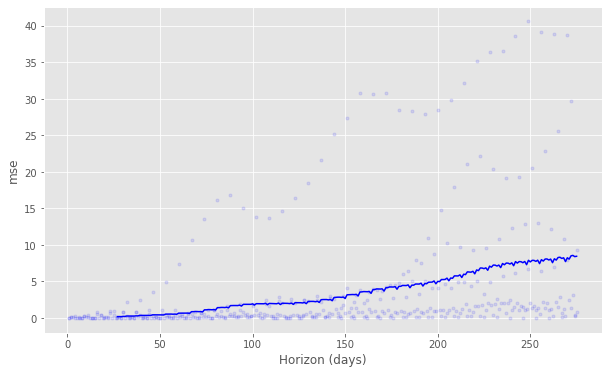

In [772]:
fig = plot_cross_validation_metric(df_cv2, metric='mse')

In [757]:
future=model.make_future_dataframe(periods=52,freq='W')
future.tail()

ds
368 2022-08-28
369 2022-09-04
370 2022-09-11
371 2022-09-18
372 2022-09-25

In [758]:
future.shape

(373, 1)

In [759]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
368 2022-08-28  10.427396    6.398826   14.530437
369 2022-09-04  10.436537    6.310830   14.716242
370 2022-09-11  10.441669    6.193213   14.894710
371 2022-09-18  10.449751    6.016787   15.190960
372 2022-09-25  10.463803    5.831599   15.258495

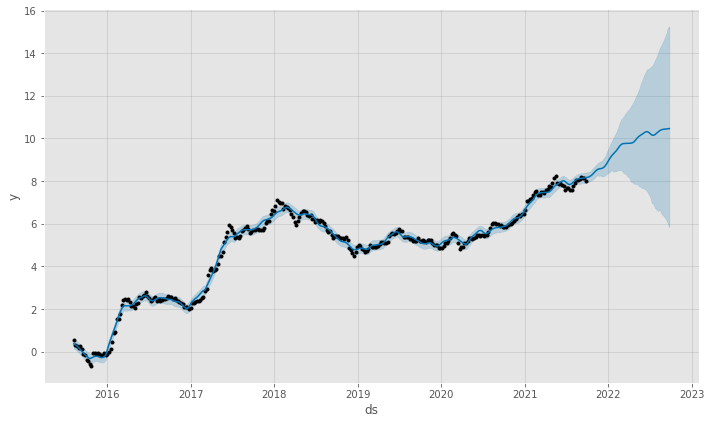

In [760]:
fig1=model.plot(forecast)

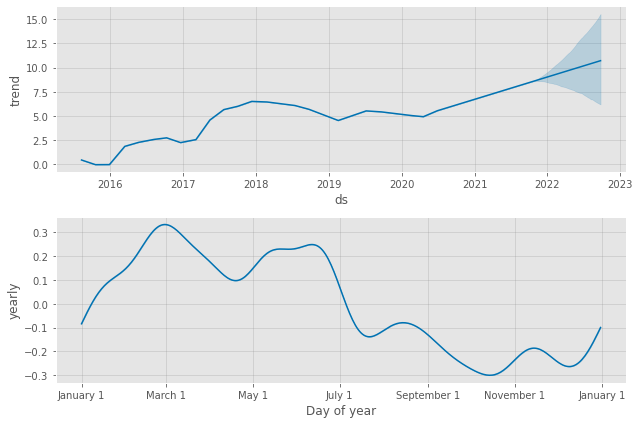

In [761]:
fig2=model.plot_components(forecast)

In [762]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

## RESULTS

### ARIMA Model Results

In [551]:
ARIMA_MSE, ARIMA_MAE

(0.6627372765182725, 0.6007977660404914)

In [562]:
ARIMA_1YR_Price = np.exp(future_weeks['Prediction'][-1])
ARIMA_1YR_Price

9070.152600691936

In [577]:
print("Model 1: ARIMA predicts " + "$"+str(np.round(ARIMA_1YR_Price,2))+ " price by " + str(future_weeks.index[-1]) + ", a " + str(np.round(abs(y['Price'][-1]-ARIMA_1YR_Price)/y['Price'][-1]*100,2))+"% increase from current prices.")

Model 1: ARIMA predicts $9070.15 price by 2022-09-25 00:00:00, a 195.03% increase from current prices.


### FB Prohphet Results

In [763]:
FPROPHET_MSE = mean_squared_error(y_log, forecast['yhat'][:322])

In [764]:
FPROPHET_RMSE= np.sqrt(FPROPHET_MSE)

In [765]:
FBPROPHET_MAE = mean_absolute_error(y_log, forecast['yhat'][:322])

In [766]:
FPROPHET_MSE, FBPROPHET_MAE

(0.03274223957128368, 0.14327352623820105)

In [768]:
prophet_forecast = forecast[['yhat']]
FBPROPHET_1YR_Price = np.exp(prophet_forecast['yhat'][372])
FBPROPHET_1YR_Price 

35024.491036545856

In [775]:
prophet_forecast_upper = forecast[['yhat_upper']]
FBPROPHET_1YR_Price_upper = np.exp(prophet_forecast_upper['yhat_upper'][372])
FBPROPHET_1YR_Price_upper 

4233311.346855208

In [776]:
prophet_forecast_lower = forecast[['yhat_lower']]
FBPROPHET_1YR_Price_lower = np.exp(prophet_forecast_lower['yhat_lower'][372])
FBPROPHET_1YR_Price_lower 

340.9034140810478

In [769]:
print("Model 2: FB_Prophet predicts " + "$"+str(np.round(FBPROPHET_1YR_Price,2))+ " price by " + str(forecast['ds'][372]) + ", a " + str(np.round(abs(y['Price'][-1]-FBPROPHET_1YR_Price)/y['Price'][-1]*100,2))+"% increase from current prices.")

Model 2: FB_Prophet predicts $35024.49 price by 2022-09-25 00:00:00, a 1039.27% increase from current prices.
